In [2]:
from zipfile import ZipFile
import numpy as np
import mxnet as mx

display_step=5

In [3]:
class DataLoader(object):
    DIR=None
    import os
    print(os.getcwd())
    
    def __init__(self):
        self.DIR = './'
    
    # Returns images and labels corresponding for training and testing. Default mode is train. 
    # For retrieving test data pass mode as 'test' in function call.
    def load_data(self, mode = 'train'):
        label_filename = mode + '_labels'
        image_filename = mode + '_images'
        label_zip = self.DIR + label_filename + '.zip'
        image_zip = self.DIR + image_filename + '.zip'
        with ZipFile(label_zip, 'r') as lblzip:
            labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
        with ZipFile(image_zip, 'r') as imgzip:
            images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels
    
    
    def create_batches(self,train_size):
        '''
        Handles the train-validation split 
        Params:
            train_size: ratio of train_size : float
        Returns:
            images, labels, validation images, validation labels in that order
        '''
        img,labels=self.load_data()
        n=labels.shape[0]
        #split into train and validation data
        validation_img=img[int(train_size*n):]
        img=img[:int(train_size*n)]
        validation_labels=labels[int(train_size*n):]
        labels=labels[:int(train_size*n)]
        return img, labels, validation_img, validation_labels        

/home/bt3/15CS10057/dl


### Network 1:

In [48]:
n_epochs=50
data = mx.symbol.Variable('data')
fc1  = mx.symbol.FullyConnected(data = data, num_hidden=512,name='fc1')
act1 = mx.symbol.Activation(data = fc1, act_type="relu",name='act1')
fc2  = mx.symbol.FullyConnected(data = act1, num_hidden = 128,name='fc2')
act2 = mx.symbol.Activation(data = fc2, act_type="relu",name='act2')
fc3  = mx.symbol.FullyConnected(data = act2, num_hidden = 64,name='fc3')
act3 = mx.symbol.Activation(data = fc3, act_type="relu",name='act3')
fc4  = mx.symbol.FullyConnected(data = act3, num_hidden = 32,name='fc4')
act4 = mx.symbol.Activation(data = fc4, act_type="relu",name='act4')
fc5  = mx.symbol.FullyConnected(data = act4, num_hidden = 16,name='fc5')
act5 = mx.symbol.Activation(data = fc5, act_type="relu",name='act5')
#output layer
fc6  = mx.symbol.FullyConnected(data = act5, num_hidden=10,name='fc6')
mlp  = mx.symbol.SoftmaxOutput(data = fc6,name='softmax')

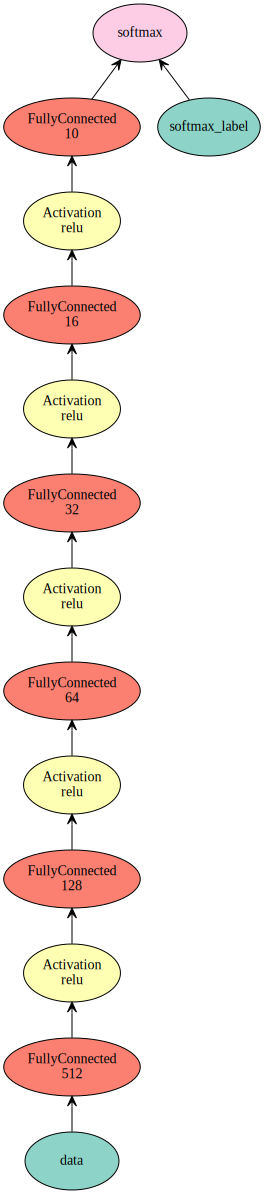

In [49]:
mx.viz.plot_network(mlp, node_attrs={"shape":"oval","fixedsize":"false"})

In [50]:
data_loader=DataLoader()
data,label,val_data,val_labels=data_loader.create_batches(train_size=0.7)
batch_size = 100
ntrain = int(data.shape[0]*0.8)
train_iter = mx.io.NDArrayIter(data, label, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(val_data, val_labels,batch_size=val_data.shape[0])

In [36]:
#starting the training of network 1

# data for plotting finally
train_1_loss=[]
train_1_acc=[]
val_1_loss=[]
val_1_acc=[]

In [52]:
mod = mx.mod.Module(symbol=mlp,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=.1))
learn_rate=0.001
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', learn_rate), ))
# use accuracy as the metric
metric = mx.metric.CrossEntropy()
metric2= mx.metric.create('acc')
for epoch in range(n_epochs):
    train_iter.reset()
    metric.reset()
    metric2.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction loss
        mod.update_metric(metric2, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    loss=metric.get()
    acc=metric2.get()
    train_1_loss.append(loss)
    train_1_acc.append(acc)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Training %s' % (epoch+1,acc))
    #validation error and accuracy
    metric.reset()
    metric2.reset()
    val_iter.reset()
    for batch in val_iter:
        mod.forward(batch)
        mod.update_metric(metric,batch.label)
        mod.update_metric(metric2,batch.label)
    loss=metric.get()
    acc=metric2.get()
    val_1_loss.append(loss)
    val_1_acc.append(acc)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Validation %s' % (epoch+1,acc))
        
mod.save_params('network1')

Epoch 1, Training ('accuracy', 0.48988095238095236)
Epoch 1, Validation ('accuracy', 0.67500000000000004)
Epoch 6, Training ('accuracy', 0.81292857142857144)
Epoch 6, Validation ('accuracy', 0.80494444444444446)
Epoch 11, Training ('accuracy', 0.83907142857142858)
Epoch 11, Validation ('accuracy', 0.82627777777777778)
Epoch 16, Training ('accuracy', 0.85207142857142859)
Epoch 16, Validation ('accuracy', 0.83966666666666667)
Epoch 21, Training ('accuracy', 0.86247619047619051)
Epoch 21, Validation ('accuracy', 0.84788888888888891)
Epoch 26, Training ('accuracy', 0.87009523809523814)
Epoch 26, Validation ('accuracy', 0.85211111111111115)
Epoch 31, Training ('accuracy', 0.87604761904761907)
Epoch 31, Validation ('accuracy', 0.85550000000000004)
Epoch 36, Training ('accuracy', 0.88195238095238093)
Epoch 36, Validation ('accuracy', 0.85855555555555552)
Epoch 41, Training ('accuracy', 0.88661904761904764)
Epoch 41, Validation ('accuracy', 0.86083333333333334)
Epoch 46, Training ('accuracy', 

***


### Network 2

In [13]:
n_epochs=50
data_2 = mx.symbol.Variable('data')
fc1_2  = mx.symbol.FullyConnected(data = data_2, num_hidden=1024,name='fc1')
act1_2 = mx.symbol.Activation(data = fc1_2, act_type="relu",name='act1')
fc2_2  = mx.symbol.FullyConnected(data = act1_2, num_hidden = 512,name='fc2')
act2_2 = mx.symbol.Activation(data = fc2_2, act_type="relu",name='act2')
fc3_2  = mx.symbol.FullyConnected(data = act2_2, num_hidden = 256,name='fc3')
act3_2 = mx.symbol.Activation(data = fc3_2, act_type="relu",name='act3')

#output layer
fc4_2  = mx.symbol.FullyConnected(data = act3_2, num_hidden=10,name='fc4')
mlp_2 = mx.symbol.SoftmaxOutput(data = fc4_2,name='softmax')

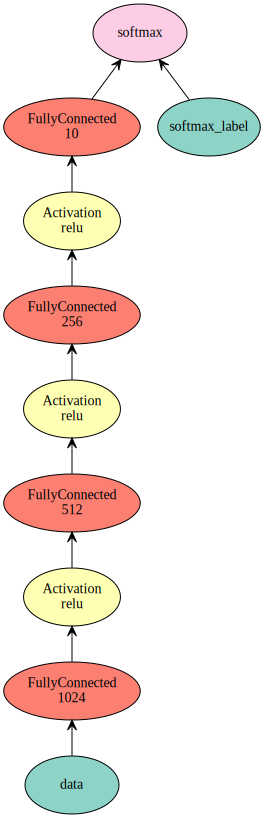

In [14]:
mx.viz.plot_network(mlp_2, node_attrs={"shape":"oval","fixedsize":"false"})

In [15]:
train_2_loss=[]
train_2_acc=[]
val_2_loss=[]
val_2_acc=[]

mod_2 = mx.mod.Module(symbol=mlp_2,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# allocate memory given the input data and label shapes
mod_2.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod_2.init_params(initializer=mx.init.Uniform(scale=.1))
learn_rate=0.001
mod_2.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', learn_rate), ))
# use accuracy as the metric
metric = mx.metric.CrossEntropy()
metric2= mx.metric.create('acc')
for epoch in range(n_epochs):
    train_iter.reset()
    metric.reset()
    metric2.reset()
    for batch in train_iter:
        mod_2.forward(batch, is_train=True)       # compute predictions
        mod_2.update_metric(metric, batch.label)  # accumulate prediction loss
        mod_2.update_metric(metric2, batch.label)  # accumulate prediction accuracy
        mod_2.backward()                          # compute gradients
        mod_2.update()                            # update parameters
    loss=metric.get()
    acc=metric2.get()
    train_2_loss.append(loss)
    train_2_acc.append(acc)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Training %s' % (epoch+1,acc))
    #validation error and accuracy
    metric.reset()
    metric2.reset()
    val_iter.reset()
    for batch in val_iter:
        mod_2.forward(batch)
        mod_2.update_metric(metric,batch.label)
        mod_2.update_metric(metric2,batch.label)
    loss=metric.get()
    acc=metric2.get()
    val_2_loss.append(loss)
    val_2_acc.append(acc)
    if epoch%display_step==0 or epoch==n_epochs-1:
        print('Epoch %d, Validation %s' % (epoch+1,acc))

Epoch 1, Training ('accuracy', 0.68414285714285716)
Epoch 1, Validation ('accuracy', 0.75461111111111112)
Epoch 6, Training ('accuracy', 0.83171428571428574)
Epoch 6, Validation ('accuracy', 0.81933333333333336)
Epoch 11, Training ('accuracy', 0.85804761904761906)
Epoch 11, Validation ('accuracy', 0.8338888888888889)
Epoch 16, Training ('accuracy', 0.87480952380952381)
Epoch 16, Validation ('accuracy', 0.84183333333333332)
Epoch 21, Training ('accuracy', 0.88664285714285718)
Epoch 21, Validation ('accuracy', 0.84433333333333338)
Epoch 26, Training ('accuracy', 0.89580952380952383)
Epoch 26, Validation ('accuracy', 0.8469444444444445)
Epoch 31, Training ('accuracy', 0.90364285714285719)
Epoch 31, Validation ('accuracy', 0.84783333333333333)
Epoch 36, Training ('accuracy', 0.90983333333333338)
Epoch 36, Validation ('accuracy', 0.84988888888888892)
Epoch 41, Training ('accuracy', 0.91554761904761905)
Epoch 41, Validation ('accuracy', 0.85016666666666663)
Epoch 46, Training ('accuracy', 0.

### Saving the models and network 2 data:

In [17]:
mod.save_params('network1')
mod_2.save_params('network2')
import pickle
pickle.dump(train_2_loss, open('train_2_loss','wb'))

***

### Comparing the 2 networks on the test data - which has been left untouched so far

In [18]:
test_img,test_labels=data_loader.load_data(mode='test')
metric = mx.metric.CrossEntropy()
metric2= mx.metric.create('acc')
test_iter = mx.io.NDArrayIter(test_img, test_labels,batch_size=test_img.shape[0])

metric.reset()
metric2.reset()
net1_acc=mod.score(test_iter,metric2)
net1_loss=mod.score(test_iter,metric)
net2_acc=mod_2.score(test_iter,metric2)
net2_loss=mod_2.score(test_iter,metric)

print("Results on test data: ")
print("Net 1: Accuracy: ",net1_acc)
print("Net 1: Cross-Entropy loss: ",net1_loss)
print("Net 2: Accuracy: ",net2_acc)
print("Net 2: Cross-Entropy loss: ",net2_loss)

Results on test data: 
Net 1: Accuracy:  [('accuracy', 0.85919999999999996)]
Net 1: Cross-Entropy loss:  [('cross-entropy', 0.39792304687500002)]
Net 2: Accuracy:  [('accuracy', 0.84609999999999996)]
Net 2: Cross-Entropy loss:  [('cross-entropy', 0.51931982421875)]


### Plotting relevant data for both

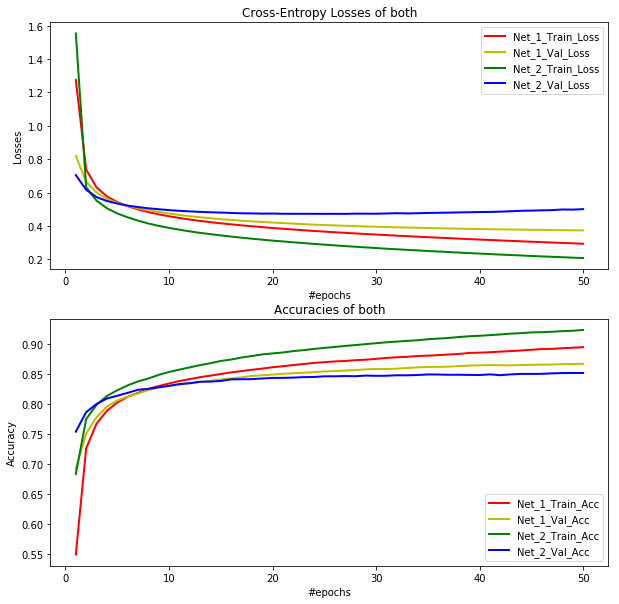

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))


plt.subplot(2, 1, 1)
l1,l2,l3,l4=plt.plot(range(1,51),[v[1] for v in train_1_loss],range(1,51),[v[1] for v in val_1_loss],\
              range(1,51),[v[1] for v in train_2_loss],range(1,51),[v[1] for v in val_2_loss])
plt.setp(l1,linewidth=2,color='r')
plt.setp(l2,linewidth=2,color='y')
plt.setp(l3,linewidth=2,color='g')
plt.setp(l4,linewidth=2,color='b')
plt.legend([l1,l2,l3,l4],['Net_1_Train_Loss','Net_1_Val_Loss','Net_2_Train_Loss','Net_2_Val_Loss'])
plt.xlabel('#epochs')
plt.ylabel('Losses')
plt.title('Cross-Entropy Losses of both')

plt.subplot(2, 1, 2)
l1,l2,l3,l4=plt.plot(range(1,51),[v[1] for v in train_1_acc],range(1,51),[v[1] for v in val_1_acc],\
              range(1,51),[v[1] for v in train_2_acc],range(1,51),[v[1] for v in val_2_acc])
plt.setp(l1,linewidth=2,color='r')
plt.setp(l2,linewidth=2,color='y')
plt.setp(l3,linewidth=2,color='g')
plt.setp(l4,linewidth=2,color='b')
plt.legend([l1,l2,l3,l4],['Net_1_Train_Acc','Net_1_Val_Acc','Net_2_Train_Acc','Net_2_Val_Acc'])
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies of both')


plt.show()
